This project applies Natural Language Processing Algorithms (NLP) on Tweets data to analyze and gain some useful insights about 2021 Canadian Elections. 

In [ ]:
# Install wordcloud library 
!pip3 install wordcloud

In [ ]:
# install xgboost library 
!pip install xgboost

In [ ]:
# import necessary libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy 

In [ ]:
# inport libraries
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
import re 
import html 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer 

from collections import defaultdict 
from wordcloud import WordCloud 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# import libraries 
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 

In [ ]:
# install tree library 
!pip install tree

     |████████████████████████████████| 67 kB 3.8 MB/s 
  Created wheel for tree: filename=Tree-0.2.4-py3-none-any.whl size=7873 sha256=6cf676d48c17e6830feb894f23dd2e3c8410b1e93d14f92e7baa10ba0db3f088
  Stored in directory: /root/.cache/pip/wheels/64/46/53/3a413f321c09b0df8d4a26edd5fc3501c6c1b238497d166638
Successfully built tree


In [ ]:
#import model implementation and tuning libraries 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

from xgboost import XGBClassifier 
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix 
from tqdm.notebook import tqdm_notebook, trange 
import time 
from sklearn.model_selection import GridSearchCV


In [ ]:
# import libraries 
from sklearn import tree

In [ ]:
# import libraries 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 

In [ ]:
# read sentiment_analysis.csv into python 
from google.colab import files 
uploaded = files.upload()
df_sentiment = pd.read_csv('sentiment_analysis.csv', low_memory = False)
df_sentiment.head()


Saving sentiment_analysis.csv to sentiment_analysis (1).csv


,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


In [ ]:
# read canadian elections data into python 
from google.colab import files 
uploaded = files.upload()
df_election = pd.read_csv('Canadian_elections_2021.csv', low_memory = False)
df_election.head()

Saving Canadian_elections_2021.csv to Canadian_elections_2021 (1).csv


,text,sentiment,negative_reason
0,The Canadian election is a power grab by PM Tr...,negative,calling election early
1,I do hope Trudeau loses the Canadian election ...,negative,covid
2,"Dear Canadians, This election is a test of how...",positive,NaN
3,Canadian friends: Never forget that Trudeau ha...,negative,calling election early
4,Sorry @theJagmeetSingh I have voted #NDP all m...,positive,NaN


# 1. Data Cleaning 

In [ ]:
# Remove Emojis 
def remove_emojis(text):
    emoji = re.compile("["
                      u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF" 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji.sub(r'', text)
    return text 

In [ ]:
# Remove URLs
def remove_URLs(text):
    return re.sub(r'http\S+', '', text)

In [ ]:
# Change all characters in the text into lowercases
def change_into_lowercase (text):
    return text.lower()

# Remove stopwords 
def remove_stopwords(text):
    tokenized_list = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_list = [x for x in tokenized_list if x not in stop_words]
    return ' '.join(filtered_list)


In [ ]:
# Remove punctuations
def remove_punctuation (text):
    return re.sub(r'[^\w\s]','', text)

In [ ]:
def data_cleaning (text):
    text = text.apply(remove_emojis) #remove emojis 
    text = text.apply(remove_URLs) #remove URLs
    text = text.apply(lambda x: x.lower()) #Change all characteristics in the text into lowercases
    return text 

Note: since I need to extract keywords with hastags (#s) and @s, I only do the pipelines with the first three actions on sentiment data: remove Emojis, URLs and change into lowercases.

In [ ]:
#Clean sentiment data with removing Emojis, URLs, and Changing into lowercases these pipelines 
df_sentiment['cleaned_text'] = df_sentiment['text'].astype(str)
df_sentiment['cleaned_text'] = data_cleaning(df_sentiment['cleaned_text'])

In [ ]:
#Remove stopwords on sentiment data 
df_sentiment['cleaned_text'] = df_sentiment['cleaned_text'].apply(remove_stopwords) 


In [ ]:
#remove punctuations on sentiment data 
df_sentiment['cleaned_text'] = df_sentiment['cleaned_text'].apply(remove_punctuation)

In [ ]:
df_sentiment.head()

,ID,text,label,cleaned_text
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1,josh jenkins looking forward tab breeders crow...
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1,rt mianusmanjaved congratulations pakistan b...
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1,rt pepalerts september yesmag taking maine...
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1,rt david_gaibis newly painted walls thanks ...
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1,rt cedricfeschotte excited announce july 20...


Note: since I need to extract keywords with hastags (#s) and @s, I only do the pipelines with the first three actions on election data: remove Emojis, URLs and change into lowercases.

In [ ]:
#Clean election data with removing Emojis and URLs and changing into lowercases 
df_election['cleaned_text'] = df_election['text'].astype(str)
df_election['cleaned_text'] = data_cleaning(df_election['cleaned_text'])

In [ ]:
#Display the relevant hashtags (#) and (@) that can indicate the political affiliations of specific tweets
# extract keywords related to political affiliations before removing punctuations (Note: I manually identify the keywords)

hash_list = []
for i in range(len(df_election)):
  for word in df_election.iloc[i]['cleaned_text'].split():
    if '@' in word or '#' in word:
      hash_list.append(word)

In [ ]:
# Count the frequency of each (hashtag + keyword)or (@ + keyword), this will help me to manually determine the keyword list for each party and further determine the political affiliation of each tweet
dictionary_list ={}
for word in hash_list:
  if word in dictionary_list:
    dictionary_list[word] = dictionary_list[word] + 1
  else:
    dictionary_list[word] = 1

In [ ]:
# Remove the keyword with frequency = 1 in dictionary_list, the frequency = 1 cannot give us too much information 
for word in dictionary_list.copy():
  if dictionary_list[word] <= 1:
    del dictionary_list[word]

In [ ]:
# Display the 'hashtag + keyword' or '@+keyword' with significant frequency (here I define 'significant' as frequency > 1)
# This helps me to manually determine the keyword list for each party according to their contents and frequenies
dictionary_list

{'#2tierotoole': 2,
 '#ableg': 2,
 '#abpoli': 2,
 '#alberta': 2,
 '#anythingbutconservative': 2,
 '#basicincome': 2,
 '#canada': 9,
 '#canadaelection': 9,
 '#canadavotes': 2,
 '#canadian': 3,
 '#canadianelection': 8,
 '#canadians': 4,
 '#cdnmedia': 2,
 '#cdnpoli': 86,
 '#climatechange': 3,
 '#conservative': 6,
 '#conservatives': 2,
 '#covid19': 3,
 '#cpc': 4,
 '#debatdeschefs': 6,
 '#debate': 3,
 '#debate2021': 4,
 '#debatenight': 2,
 '#debatsdeschefs': 2,
 '#election': 2,
 '#election2021': 5,
 '#elections2021': 15,
 '#elexn44': 3,
 '#elxn2021': 2,
 '#elxn44': 114,
 '#elxn44vote': 2,
 '#flipflopotoole': 5,
 '#forwardforeveryone': 9,
 '#freedom': 3,
 '#gettheshot': 2,
 '#hypocrite': 2,
 '#istandwithtrudeau': 23,
 '#itsourvote': 2,
 '#justintrudeau': 4,
 '#leadersdebate': 6,
 '#liberalmajority': 7,
 '#lpc': 2,
 '#makemaxourpm': 3,
 '#maximebernier': 5,
 '#maximebernierforpm': 3,
 '#morocco': 2,
 '#ndp': 7,
 '#ndp2021': 3,
 '#nevervoteconservative': 50,
 '#nevervotecpc': 10,
 '#onpoli': 5

In [ ]:
# Remove stopwords on elelection data 
df_election['cleaned_text'] = df_election['cleaned_text'].apply(remove_stopwords)

In [ ]:
# Remove punctuations on election data
df_election['cleaned_text'] = df_election['cleaned_text'].apply(remove_punctuation)

In [ ]:
df_election.head()

,text,sentiment,negative_reason,cleaned_text
0,The Canadian election is a power grab by PM Tr...,negative,calling election early,canadian election power grab pm trudeau yes ...
1,I do hope Trudeau loses the Canadian election ...,negative,covid,hope trudeau loses canadian election tomorrow ...
2,"Dear Canadians, This election is a test of how...",positive,NaN,dear canadians election test progressive whe...
3,Canadian friends: Never forget that Trudeau ha...,negative,calling election early,canadian friends never forget trudeau 2 years...
4,Sorry @theJagmeetSingh I have voted #NDP all m...,positive,NaN,sorry thejagmeetsingh voted ndp life electio...


# 2. Exploratory Data Analysis

The procedure to determine the political affiliation of specific tweet: 

1. Extract and display the key words containing hashtages ('#') and ('@') which can determine the political affiliations before removing punctuations. This step is done in Part1 before removing punctuations. 

2. Focusing on the cleaned text after removing stopping words and punctuations , I also display and count the frequency of the keywords that can determine the political affiliations. This step is done in part 2.

3. Considering the extracted keywords and their frequencies in part1 and part2, I manually identify the list of keywords that can determine each of 4 parties. The identified keyword list for each party is shown inside of the self-defined function called 'political_party' in part2.

4. Then for specific tweet, I count the frequencies of the keywords belonging to each party's keyword list respectively. Then based on the frequencies of the keywords for each political party, I assign that tweet to the political party with highest frequency of keywords. The detailed processes is shown in the self-defined function 'political_party' in part2. 

In [ ]:
#Get the frequency of words in election data and further identify the keywords for each party 
count_vector = CountVectorizer()
wordcount = count_vector.fit_transform(df_election['cleaned_text'].astype(str))
df = pd.DataFrame.sparse.from_spmatrix(
    wordcount, columns = count_vector.get_feature_names())

df_frequency_rank = df.sum(axis = 0).sort_values(ascending = False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df_frequency_rank

election      659
trudeau       335
canadians     283
otoole        245
canadian      242
             ... 
heath           1
heed            1
heels           1
height          1
laboratory      1
Length: 4403, dtype: int64

In [ ]:
# To identify the keywords shown in election data in descending order 
#df_frequency_rank.index.tolist()

Belowing keyword list for each political party is identified based on the extracted keywords with hashtags (#) and @s done in part 1 and the counted keywords related to each party done in part 2. 

In [ ]:
# Write the function to determine the person belonging to which political party 
def political_party(text):
    conservative_list = [ 'erinotoole', 'otootle','conservative', 'conservatives', 'cpc','toole', 'otooleforpm',
                         'voteconservative', 'h_toole']
    liberal_list = ['trudeau', 'justintrudeau', 'justin', 'teamtrudeau','nt', 'cdnpoli', 'liberal', 'liberals', 'voteliberal','istandwithtrudeau','liberal_party'
    'voteliberalmajority', 'liberalmajority', 'trump','justintrudeausaved']
    NDP_list = ['ndp', 'new', 'thejagmeetsingh', 'jagmeet', 'climate', 'ndp2021', 'votendp']
    PPC_list = ['people','ppc', 'voteppc', 'maximebernier', 'voteppc2021', 'peoplespca', 'ppl','ppc2021']
    
    conservative_count = 0 
    liberal_count = 0
    NDP_count = 0 
    PPC_count = 0 
    political_party = 'party'
    
    for word in str(text).split(" "):
        if word in conservative_list: 
            conservative_count = conservative_count + 1
        if word in liberal_list:
            liberal_count = liberal_count + 1 
        if word in NDP_list:
            NDP_count = NDP_count + 1 
        if word in PPC_list:
            PPC_count = PPC_count + 1 
            
    if max(conservative_count, liberal_count, NDP_count, PPC_count) == conservative_count: 
        political_party = 'Conservative Party'
    elif max(conservative_count, liberal_count, NDP_count, PPC_count) == liberal_count:
        political_party = 'Liberal Party'
    elif max(conservative_count, liberal_count, NDP_count, PPC_count) == NDP_count:
        political_party = 'NDP Party'
    elif max(conservative_count, liberal_count, NDP_count, PPC_count) == PPC_count:
        political_party = 'PPC Party'
    return political_party

In [ ]:
# Show the number of participants in each of 4 party 
df_election['Political_Party'] = df_election['cleaned_text'].apply(political_party)
print(df_election['Political_Party'].value_counts(),'\n')

Liberal Party         474
Conservative Party    419
PPC Party              78
NDP Party              31
Name: Political_Party, dtype: int64 



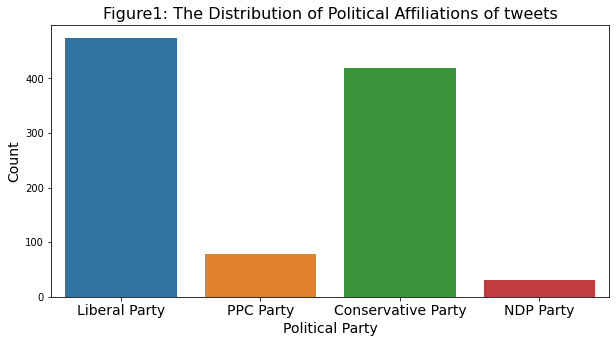

In [ ]:
# Plot the figure of the distribution of political affiliations of the tweets 
fig, ax = plt.subplots(figsize = (10,5))
sns.countplot(x = 'Political_Party', data = df_election)
plt.title("Figure1: The Distribution of Political Affiliations of tweets", fontsize = 16)
plt.xticks(fontsize = 14)
ax.set_xlabel('Political Party', fontsize = 14)
ax.set_ylabel('Count', fontsize = 14)
plt.show()

Findings from Figure1:

In [ ]:
print("Findings:")
print("As seen in Figure 1, the tweets that belonging to the liberal party has the highest count. ")
print("The tweets that belonging to the NDP party has the lowest count.")
print("Total number of tweets belonging to the conservative party is slightly fewer than the total number of tweets belonging to the liberal party.")
print("The liberal party counts and the conservative party counts are much larger than the PPC party counts and NDP party counts.")

Findings:
As seen in Figure 1, the tweets that belonging to the liberal party has the highest count. 
The tweets that belonging to the NDP party has the lowest count.
Total number of tweets belonging to the conservative party is slightly fewer than the total number of tweets belonging to the liberal party.
The liberal party counts and the conservative party counts are much larger than the PPC party counts and NDP party counts.


Visualization of some aspects of Canadian elections data and Sentiment analysis data 

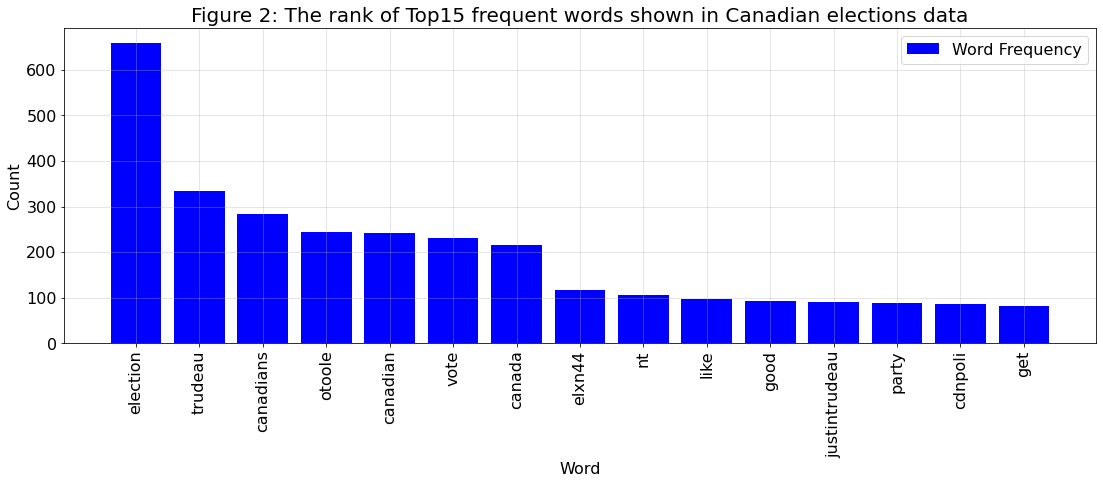

In [ ]:
# plot the bar chart of the word frequency rank for Top 15 frequent words in Canadian_election data
fig, ax = plt.subplots(figsize = (15,6))
plt.bar(df_frequency_rank.index[0:15], df_frequency_rank[0:15], label = "Word Frequency", color = 'blue')

#Formatting
plt.xticks(rotation = 90)
ax.legend()
plt.title("Figure 2: The rank of Top15 frequent words shown in Canadian elections data", fontsize = 20)
plt.grid(alpha = 0.4)
plt.tight_layout()
ax.set_xlabel('Word', fontsize = 16)
ax.set_ylabel('Count', fontsize = 16)
plt.yticks(fontsize = 16)
plt.xticks (fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

In [ ]:
#  count the top 100 frequent words shown in the Canadian elections data 
election_dict = {}
for index, value in df_frequency_rank[:100].iteritems():
  election_dict[index] = value

(-0.5, 2999.5, 1999.5, -0.5)

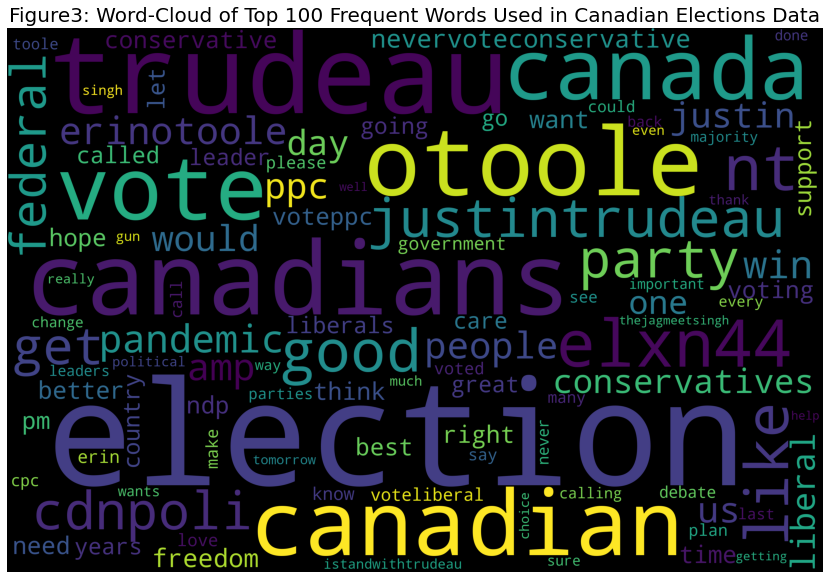

In [ ]:
#Draw the Word-Cloud of the Top 100 words used in Canadian elections data 
from wordcloud import WordCloud

wordcloud = WordCloud(width = 3000, height = 2000, random_state = 21).generate_from_frequencies(election_dict)

plt.figure(figsize = (20,10))
plt.title("Figure3: Word-Cloud of Top 100 Frequent Words Used in Canadian Elections Data", fontsize = 20)
plt.imshow(wordcloud)
plt.axis('off')

Findings from Figure 2 and 3 (Visualization in Canadian elections data):

In [ ]:
print("Findsings: From Figure2 and Figure3, we can see that 'election' is the most frequent word shown in generic tweets in sentiment data, which corresponds with the topic of those tweets. \n")
print("Furthermore, the word like 'trudeau' , 'canadians', 'otoole', 'canadian', 'vote', 'Canada' are also very frequent and popular.")

Findsings: From Figure2 and Figure3, we can see that 'election' is the most frequent word shown in generic tweets in sentiment data, which corresponds with the topic of those tweets. 

Furthermore, the word like 'trudeau' , 'canadians', 'otoole', 'canadian', 'vote', 'Canada' are also very frequent and popular.


In [ ]:
# count the top 20 frequent word shown in sentiment analysis data 
count_vector2 = CountVectorizer(min_df = 200)
wordcounts2 = count_vector2.fit_transform(df_sentiment['cleaned_text'].astype(str))
df2 = pd.DataFrame.sparse.from_spmatrix(wordcounts2, columns = count_vector2.get_feature_names())

df2 = df2.sum(axis = 0).sort_values(ascending = False)[0:20]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


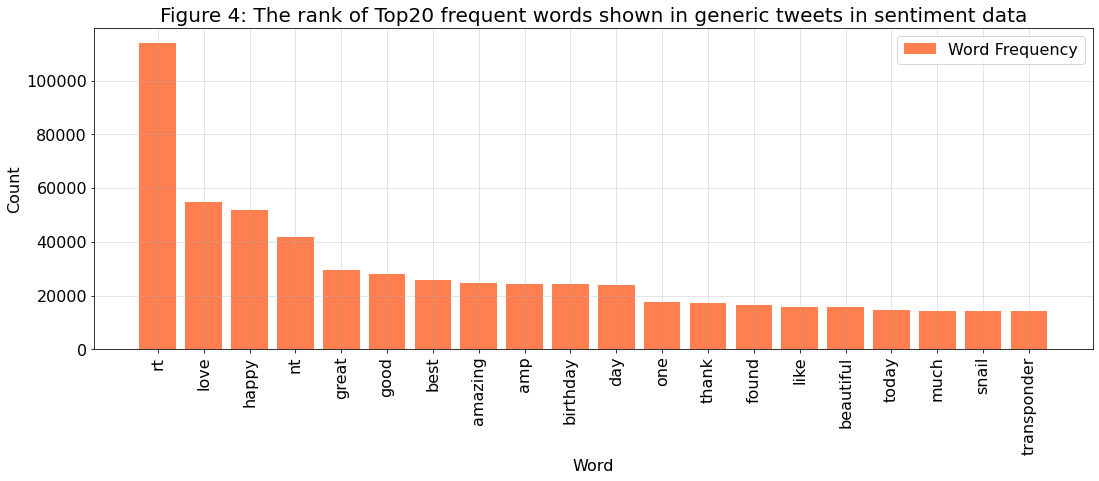

In [ ]:
# plot the bar chart of the word frequency rank for Top 20 frequent words of the generic tweets in sentiment_analysis data
fig, ax = plt.subplots(figsize = (15,6))
plt.bar(df2.index, df2, label = "Word Frequency", color = 'coral')

#Formatting
plt.xticks(rotation = 90)
ax.legend()
plt.title("Figure 4: The rank of Top20 frequent words shown in generic tweets in sentiment data", fontsize = 20)
plt.grid(alpha = 0.4)
plt.tight_layout()
ax.set_xlabel('Word', fontsize = 16)
ax.set_ylabel('Count', fontsize = 16)
plt.yticks(fontsize = 16)
plt.xticks (fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

In [ ]:
# Display and count the top 100 frequent words shown in the sentiment analysis data 
df2_100 = pd.DataFrame.sparse.from_spmatrix(wordcounts2, columns = count_vector2.get_feature_names()).sum(axis = 0).sort_values(ascending = False)[:100]
sentiment_dict = {}
for index, value in df2_100.iteritems():
  sentiment_dict[index] = value

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(-0.5, 2999.5, 1999.5, -0.5)

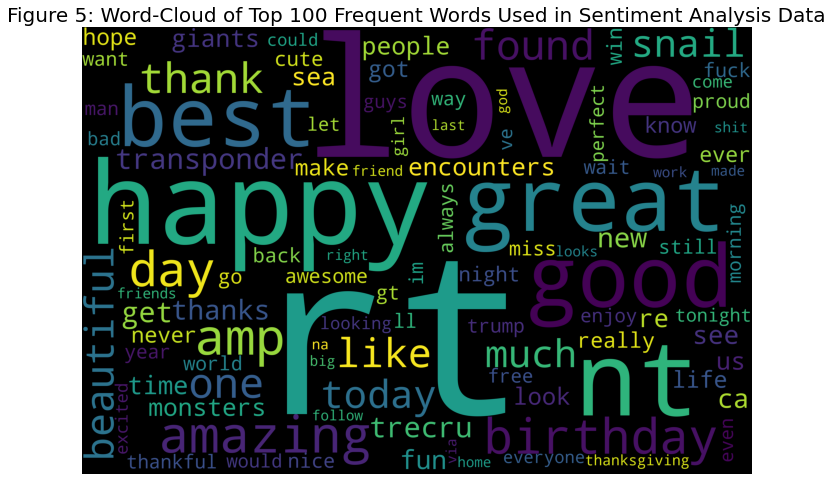

In [ ]:
#Draw the Word-Cloud of the Top 100 words used in sentiment analysis data 
wordcloud = WordCloud(width = 3000, height = 2000, random_state = 42).generate_from_frequencies(sentiment_dict)

plt.figure(figsize = (12,10))
plt.title("Figure 5: Word-Cloud of Top 100 Frequent Words Used in Sentiment Analysis Data", fontsize = 20)
plt.imshow(wordcloud)
plt.axis('off')

Findings from Figure 4 and 5 (visualization in sentiment analysis data): 

In [ ]:
print("Findings: From Figure4 and Figure5, we can see that 'rt', 'love', 'happy', 'nt' are the most popular and frequent words used in generic tweets in sentiment data. \n")
print("Also words like 'great' , 'good', 'best', 'amazing' are also popular among the generic tweets in sentiment data.\n")
print("This indicates that for the sentiment data, large number of tweets' contents tend to be positive and people try to express their excited expressions through the tweets.")

Findings: From Figure4 and Figure5, we can see that 'rt', 'love', 'happy', 'nt' are the most popular and frequent words used in generic tweets in sentiment data. 

Also words like 'great' , 'good', 'best', 'amazing' are also popular among the generic tweets in sentiment data.

This indicates that for the sentiment data, large number of tweets' contents tend to be positive and people try to express their excited expressions through the tweets.


# 3. Sentiment Classification - Model implementation and tuning 

In [ ]:
# Stemming on both of two datasets 
def stemming(text):
    stemmer = PorterStemmer()
    token_list = word_tokenize(text)
    stemmed_list = [stemmer.stem(x) for x in token_list]
    return ' '.join(stemmed_list)

In [ ]:
# Implement stemming on both of two datasets before splitting the data 
df_sentiment['cleaned_text'] = df_sentiment['cleaned_text'].apply(stemming)
df_election['cleaned_text'] = df_election['cleaned_text'].apply(stemming)


In [ ]:
df_sentiment['cleaned_text']

0         josh jenkin look forward tab breeder crown sup...
1         rt mianusmanjav congratul pakistan becom no1te...
2         rt pepalert septemb yesmag take main mendoza s...
3         rt david_gaibi newli paint wall thank million ...
4         rt cedricfeschott excit announc juli 2017 fesc...
                                ...                        
550386                      goddesses_o ca nt stop watch mm
550387    poor old tom odel nt look like would know wron...
550388              antsmash smash 7 ant awesom game hjfjfi
550389    lizhudston kymwylli evasmiless meanbok linddyl...
550390    bixbeat mixtap vol2 great artist join movement...
Name: cleaned_text, Length: 550391, dtype: object

### 3.a Machine Learning Models 

In [ ]:
# Split the generic tweets of sentiment data randomly into training data (80%) and testing data (20%)
x = df_sentiment['cleaned_text']
y = df_sentiment['label']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2)

In [ ]:
# prepare the data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features = 1000)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train.astype(str))
x_test_tfidf = tfidf_vectorizer.transform(x_test.astype(str))

The reason to set max_features = 1000 instead of 5000 is given below: 

When implementing seven models on training data, I choose max_features = 1000 instead of max_features = 5000 (the suggestion given in assignment instruction). This is because that when I set max_features = 1000, the accuracies of almost all the models have arrived at above 90%, which are good enough. Thus, it indicates that reducing the number of max_features will not significantly harm and bias the accuracy, further affecting our decisions. It could still remain the accuracy within the normal and reasonable range. 

Further, when I set max_features = 5000 for logistic model, from my experiment, actually its accuracy is 0.95+, compared with the model accuracy when setting max_features (0.9505), they are very close. Thus, it further proves that reducing the number of max_features to 1000 will not harm the accuracy and still maintain the ideal accuracy within the normal range.

Thus, based on above analysis, under the condition that the model accuracies are very similiar between setting max_features = 5000 and setting max_features = 1000, I decide to set the max_features = 1000 to largely reduce the computational time and capacity, increasing efficiency. 



In [ ]:
# Train seven classification algorithms on the training data from generic tweets
def model_implementation(x_train, y_train, x_test, y_test):
    model_name = ['Logistic Regression', 'KNN',  'Naive Bayes', 'SVM', 'Decision Tree', 'Random Forest', 'XGBoost']
    model = [LogisticRegression(max_iter = 1000),KNeighborsClassifier(), GaussianNB(),
             LinearSVC(random_state = 42), DecisionTreeClassifier(random_state = 42),
             RandomForestClassifier(random_state = 42), XGBClassifier()]
    accuracy_list = []
    for i in range(7):
        model[i].fit(x_train, y_train)
        predictions = model[i].predict(x_test)
        accuracy = accuracy_score(y_test, predictions)
        accuracy_list.append(accuracy)
        print("For the model {}, the accuracy is {:.4f}".format(model_name[i],accuracy))
    return accuracy_list 

In [ ]:
#Train seven classification algorithms on the training data from generic tweets and evaluate each model on the test data in generic tweets 
accuracy_list = model_implementation(x_train_tfidf.toarray(), y_train, x_test_tfidf.toarray(), y_test)

For the model Logistic Regression, the accuracy is 0.9479
For the model KNN, the accuracy is 0.8817
For the model Naive Bayes, the accuracy is 0.8683
For the model SVM, the accuracy is 0.9479
For the model Decision Tree, the accuracy is 0.9340
For the model Random Forest, the accuracy is 0.9505
For the model XGBoost, the accuracy is 0.8731


In [ ]:
# Display the accuracy for each implemented model 
model_name = ['Logistic Regression', 'K-NN','Naive Bayes', 'SVM', 'Decision Tree', 'Random Forest','XGBoost']
dict1 = {'Logistic Regression': accuracy_list[0], 'K-NN': accuracy_list[1], 'Naive Bayes': accuracy_list[2], 'SVM': accuracy_list[3], 'Decision Tree': accuracy_list[4],
        'Random Forest': accuracy_list[5], 'XGBoost': accuracy_list[6]}
accuracy_evaluation = pd.DataFrame(dict1, index=['Accuracy'])
accuracy_evaluation 

,Logistic Regression,K-NN,Naive Bayes,SVM,Decision Tree,Random Forest,XGBoost
Accuracy,0.947937,0.881721,0.868304,0.947937,0.933957,0.950481,0.873118


### 3.b Deep Learning Models

In [ ]:
# Split the generic tweets into training data (60%), validation data (20%) and test data (20%)
X = df_sentiment['cleaned_text']
Y = df_sentiment['label']
#split into 60% training data and 40% remaining data 
X_train, X_remain, Y_train, Y_remain = train_test_split(X, Y, train_size = 0.6) 
#further split 40% remaining data into validation data (20%) and test data(20%) equally
X_valid, X_test, Y_valid, Y_test = train_test_split (X_remain, Y_remain, test_size = 0.5) 

In [ ]:
#prepare the data using Bag of Words 
count_vectorizer = CountVectorizer(max_features = 1000)
X_train_count = count_vectorizer.fit_transform(X_train.astype(str))
X_valid_count = count_vectorizer.transform(X_valid.astype(str))
X_test_count = count_vectorizer.transform(X_test.astype(str))

The reason I use max_features = 1000 instead of max_features = 5000 (the suggestion given in assignment) is that previously I have used max_features = 1000 to train the machine learning models. To achieve the consistency and help me more objectively compare the models in 3(a) and in 3(b), I need to set max_features = 1000 for training the deep learning model. 

Further, as seen in below results, the accuracies for deep learning models are almost above 90%, which are high enough. This indicates that reducing max_features into 1000 will not harm my accuracy. 

Thus, based on above analysis, under the condition that the model accuracies are very similiar between setting max_features = 5000 and setting max_features = 1000, I decide to set the max_features = 1000 to largely reduce the computational time and capacity, increasing efficiency. 



In [ ]:
#Define and train a deep learning model to perform the sentiment classification 
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf



#write define_deep_learn_model function 
def define_deep_learn_model():
    deep_learn_model = Sequential()
    deep_learn_model.add(Dense(units=2, activation='sigmoid', input_dim = 1000))
    deep_learn_model.add(Dense(units = 2, activation = 'sigmoid'))
    deep_learn_model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
    return deep_learn_model


In [ ]:
# write the function to convert csr_matrix into sparse tensor 
def convert_matrix_to_tensor(matrix):
    coo = matrix.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

In [ ]:
# Convert X_train_count, X_valid_count and X_test_count into tensor 
X_train_tensor = convert_matrix_to_tensor(X_train_count)
X_valid_tensor = convert_matrix_to_tensor(X_valid_count)
X_test_tensor = convert_matrix_to_tensor(X_test_count)

In [ ]:
# Tune two hyperparameters of the deep learning model using self-defined grid search function 
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold


# Define the grid search parameters 
batch_size = [10,20]
epochs = [5, 10]
param_grid1 = dict(batch_size = batch_size, epochs = epochs)

best_params = {}
best_accuracy = 0

# write my own Grid Search function and find the best hyperparameters 
for batch in batch_size:
  for epoch in epochs:
    #define and write the deep learning model out
    deep_learn_model = KerasClassifier(build_fn = define_deep_learn_model, verbose = 0, batch_size = batch, epochs = epoch)
    #fit the deep learning model 
    deep_learn_model.fit(tf.sparse.reorder(X_train_tensor), Y_train)
    # use the deep learning model to predict on the validation data 
    deep_prediction = deep_learn_model.predict(tf.sparse.reorder(X_valid_tensor))
    # obtain the accuracy of the deep learning model 
    deep_accuracy = accuracy_score(Y_valid, deep_prediction)
    print("For the model with batchsize = {} and epoch = {}, the accuracy is {:.4f}".format(batch, epoch, deep_accuracy))
    #find and store the best deep learning model (with best parameters and its corresponding model accuracy)
    if deep_accuracy > best_accuracy:
      best_params = {'batchsize':batch, 'epochs':epoch}
      best_accuracy = deep_accuracy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 2), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


For the model with batchsize = 10 and epoch = 5, the accuracy is 0.9489


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/dense_2/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/dense_2/embedding_lookup_sparse/Reshape:0", shape=(None, 2), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_1/dense_2/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


For the model with batchsize = 10 and epoch = 10, the accuracy is 0.9496


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_2/dense_4/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_2/dense_4/embedding_lookup_sparse/Reshape:0", shape=(None, 2), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_2/dense_4/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


For the model with batchsize = 20 and epoch = 5, the accuracy is 0.9497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_3/dense_6/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_3/dense_6/embedding_lookup_sparse/Reshape:0", shape=(None, 2), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_3/dense_6/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


For the model with batchsize = 20 and epoch = 10, the accuracy is 0.9491


In [ ]:
# Display the optimal deep learning model with optimal paramters and its corresponding accuracy 
print('Best Parameters deep learning model:', best_params)
print('The Accuracy of the optimal deep learning model on validation set:', best_accuracy)

Best Parameters deep learning model: {'batchsize': 20, 'epochs': 5}
The Accuracy of the optimal deep learning model on validation set: 0.9496629662602881


In [ ]:
# Fit the optimal deep learning model and evaluate it on the test data 
best_deep_learn = KerasClassifier(build_fn = define_deep_learn_model, verbose = 0, batch_size = 20, epochs = 5)
best_deep_learn.fit(tf.sparse.reorder(X_train_tensor), Y_train)
best_prediction = best_deep_learn.predict(tf.sparse.reorder(X_test_tensor))
best_accuracy = accuracy_score(Y_test, best_prediction)
best_accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_4/dense_8/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_4/dense_8/embedding_lookup_sparse/Reshape:0", shape=(None, 2), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_4/dense_8/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


0.9490002634471607

In [ ]:
print("As seen in above result, the accuracy for the optimal deep learning model is {:.4f}".format(best_accuracy))

As seen in above result, the accuracy for the optimal deep learning model is 0.9490


### 3.C Evaluate the trained mode with best performance on the Canadian Elections data

In [ ]:
print("As seen in results from 3.a and 3.b, we can see that the accuracy of the model Random Forest is highest (accuracy = 0.9505) and thus, we can infer the best model is the Random Forest.\n")
print("Thus, we apply the RandomForestClassifier on the Canadian Elections data.")

As seen in results from 3.a and 3.b, we can see that the accuracy of the model Random Forest is highest (accuracy = 0.9505) and thus, we can infer the best model is the Random Forest.

Thus, we apply the RandomForestClassifier on the Canadian Elections data.


In [ ]:
#Encoding the sentiment column ("Positive or negative") in election data into numeric value 1 or 0 
df_election['sentiment'] = df_election['sentiment'].map({'positive':1,'negative':0}).astype(int)
df_election.sentiment.value_counts()

1    615
0    387
Name: sentiment, dtype: int64

In [ ]:
x_election = df_election['cleaned_text']
y_election = df_election['sentiment']

In [ ]:
# Prepare the election data using tfidf_vectorizer
x_election_tfidf = tfidf_vectorizer.transform(x_election.astype(str))

In [ ]:
# Implement the trained model with the best performance (random forest) on the Cnadian election data 
best_model = RandomForestClassifier(random_state = 42)
best_model.fit(x_train_tfidf[:, :42].toarray(), y_train)


RandomForestClassifier(random_state=42)

In [ ]:
election_pred = best_model.predict(x_election_tfidf[:, :42].toarray())
accuracy_best_model = accuracy_score(y_election, election_pred)
accuracy_best_model

0.6037924151696606

Dicussion of the findings from the predictions on Canadian Elections data:

In [ ]:
print('As seen in the results, the accuracy of the RandomForestClassifier model on the prediction of Canadian Elections data is 0.6038. \n')
print("This indicates only 60.38% of predictions match the sentiment labelled in the Canadian elections data.\n")
print("This prediction performance on the Canadian elections is not good. \n")
print("Overall, the best model Random Forest has the good performance on sentiment data but has the poor performance on elections data. \n")
print("Thus, I do not think the NLP analytics based on tweets is useful for political parties during election campaigns.")

As seen in the results, the accuracy of the RandomForestClassifier model on the prediction of Canadian Elections data is 0.6038. 

This indicates only 60.38% of predictions match the sentiment labelled in the Canadian elections data.

This prediction performance on the Canadian elections is not good. 

Overall, the best model Random Forest has the good performance on sentiment data but has the poor performance on elections data. 

Thus, I do not think the NLP analytics based on tweets is useful for political parties during election campaigns.


### 3.d Other two performance metrics

In [ ]:
# Glimpse the basic situations of counts of positive sentiment and negative sentiment (after encoding)
df_election['sentiment'].value_counts()

1    615
0    387
Name: sentiment, dtype: int64

In [ ]:
print("Above illusrates that the total number of positive sentiments in election data is 615 and the total number of negative sentiments in election data is 387. It looks like we do not have a balanced dataset.")

Above illusrates that the total number of positive sentiments in election data is 615 and the total number of negative sentiments in election data is 387. It looks like we do not have a balanced dataset.


In [ ]:
print("Two other evaluation metrics proposed: \n")
print("I will choose the F1_Score and confusion matrix as two other evaluation metrics.\n")
print("For F1_score, this is because that I notice that the original dataset about positive and negative sentiment is not well balanced.")
print("As we know, the F1_Score as a performance metrics is the combination of precision and recall, and can deal with the unbalanced dataset better than the accuracy.")
print("Thus, F1-score can be used to evaluate the accuracy of the model.\n")

print("For confusion matrix, I choose this because the confusion matrix can tell us what the exact True positive rate, True negative rate, False Positive rate and False nagative rate are.")
print("We can have a better understanding of the percentage of correct prediction of positive sentiment and percentage of correct prediction of neagtive sentiment.")
print("Based on the confusion matrix, we can even obtain the accuracy through calculations.")
print ("Overall, besides the overall accuracy that confusion matrix can give (through calculations), the confusion matrix could give us more detailed information about the each class performance compared with the accuracy.")
print("Thus, the confusion matrix can also be regarded as other evaluation metrics to evaluate the accuracy of the model.")


Two other evaluation metrics proposed: 

I will choose the F1_Score and confusion matrix as two other evaluation metrics.

For F1_score, this is because that I notice that the original dataset about positive and negative sentiment is not well balanced.
As we know, the F1_Score as a performance metrics is the combination of precision and recall, and can deal with the unbalanced dataset better than the accuracy.
Thus, F1-score can be used to evaluate the accuracy of the model.

For confusion matrix, I choose this because the confusion matrix can tell us what the exact True positive rate, True negative rate, False Positive rate and False nagative rate are.
We can have a better understanding of the percentage of correct prediction of positive sentiment and percentage of correct prediction of neagtive sentiment.
Based on the confusion matrix, we can even obtain the accuracy through calculations.
Overall, besides the overall accuracy that confusion matrix can give (through calculations), the

### 3.e Visualize the relevant results of the model with best performance 

In [ ]:
# Combing the predictions of Canadian election data by RandomForestClassifier into the df_election dataframe
df_election['Prediction'] = pd.Series(election_pred)

In [ ]:
# display the predictions of positive sentiment vs actual values of positive sentiment 
party_pred_pos = df_election[df_election['Prediction'] == 1]['Political_Party'].value_counts()
party_true_values_pos = df_election[df_election['sentiment'] == 1]['Political_Party'].value_counts()

positive_sentiment = pd.DataFrame([party_pred_pos, party_true_values_pos], index = ['Prediction', 'Actual Values'])
positive_sentiment 

,Liberal Party,Conservative Party,PPC Party,NDP Party
Prediction,464,405,77,30
Actual Values,255,277,56,27


In [ ]:
# display the predictions of negative sentiment vs actual values of negative sentiment
party_pred_neg = df_election[df_election['Prediction'] == 0]['Political_Party'].value_counts()
party_true_values_neg = df_election[df_election['sentiment'] == 0]['Political_Party'].value_counts()

negative_sentiment = pd.DataFrame([ party_true_values_neg, party_pred_neg], index = ['Actual Values', 'Prediction'])
negative_sentiment

,Liberal Party,Conservative Party,PPC Party,NDP Party
Actual Values,219,142,22,4
Prediction,10,14,1,1


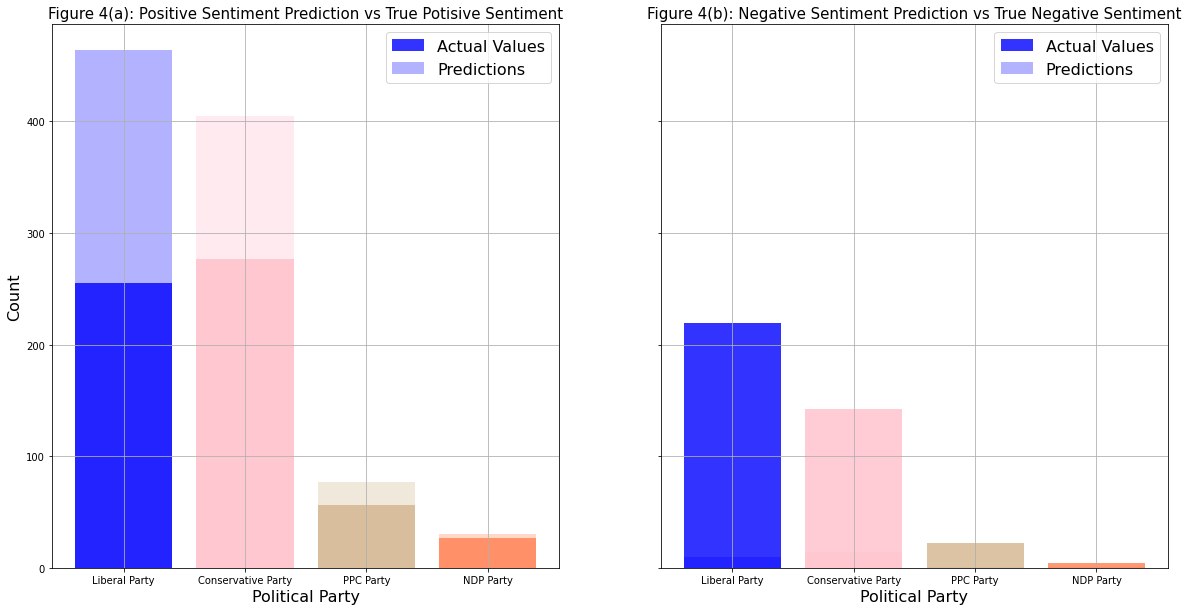

In [ ]:
#Visualize the  sentiment prediction results and the true sentiment for each of the 4 parties 
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10), sharey = True)
ax1.bar(positive_sentiment.transpose().index, positive_sentiment.transpose()['Actual Values'], color = ['blue', 'pink', 'tan', 'coral'], alpha = 0.8, label = 'Actual Values')
ax1.bar(positive_sentiment.transpose().index, positive_sentiment.transpose()['Prediction'], color = ['blue', 'pink', 'tan', 'coral'],  alpha = 0.3, label = 'Predictions')
ax1.set_xlabel('Political Party', fontsize = 16)
ax1.set_ylabel('Count', fontsize = 16)
ax1.legend(fontsize = 16)
ax1.set_title('Figure 4(a): Positive Sentiment Prediction vs True Potisive Sentiment', fontsize = 15)

ax2.bar(negative_sentiment.transpose().index, negative_sentiment.transpose()['Actual Values'], color = ['blue', 'pink', 'tan', 'coral'], alpha = 0.8, label = 'Actual Values')
ax2.bar(negative_sentiment.transpose().index, negative_sentiment.transpose()['Prediction'], color = ['blue', 'pink', 'tan', 'coral'], alpha = 0.3, label = 'Predictions')
ax2.legend(fontsize = 16, loc = 'upper right')
ax2.set_xlabel('Political Party', fontsize = 16)
ax2.set_title('Figure 4(b): Negative Sentiment Prediction vs True Negative Sentiment', fontsize = 15)
ax1.grid()
ax2.grid()
plt.show()


Discussion of findings for visualization of sentiment prediction results vs true sentiment for 4 parties:

In [ ]:
print("Findings: As seen from the Figure 4(a) and 4(b),\n ")
print("for each party, there are large inconsistencies between the predictions and actual values for both positive sentiment and negative sentiment.\n") 

Findings: As seen from the Figure 4(a) and 4(b),
 
for each party, there are large inconsistencies between the predictions and actual values for both positive sentiment and negative sentiment.



In [ ]:
print("For positive sentiment prediction vs true positive sentiment, ")
print("For liberal and conservative parties, the number of predictions is much larger than the number of actual values.")
print("for PPC party, the number of predictions is larger than the number of actual values.")
print("For NDP party, the number of predictions is approxmiately equal to the number of actual values.")

For positive sentiment prediction vs true positive sentiment, 
For liberal and conservative parties, the number of predictions is much larger than the number of actual values.
for PPC party, the number of predictions is larger than the number of actual values.
For NDP party, the number of predictions is approxmiately equal to the number of actual values.


In [ ]:
print("For negative sentiment prediction vs true negative sentiment,")
print("For liberal party, conservative party and PPC party, the number of actual values is much larger than the number of predictions.")

For negative sentiment prediction vs true negative sentiment,
For liberal party, conservative party and PPC party, the number of actual values is much larger than the number of predictions.


Explanation of how each party is viewed in the public eye based on the sentiment value: 

In [ ]:
print("For the liberal party, ")
print("For the predictions, from the public eye, they express much more positive sentiment than negative sentiment to liberal party.")
print("For the actual values, from the public eye, they express similiar amounts of positive and negative sentiment to the liberal party.")

For the liberal party, 
For the predictions, from the public eye, they express much more positive sentiment than negative sentiment to liberal party.
For the actual values, from the public eye, they express similiar amounts of positive and negative sentiment to the liberal party.


In [ ]:
print("For the conservative party,")
print("For the predictions, from the public eye, they express much more positive sentiment than negative sentiment to conservative party.")
print("For the actual values, from the public eye, they express more (the extent is sligher than the extent for predictions) positive sentiment than negative sentiment to conservative party. ")

For the conservative party,
For the predictions, from the public eye, they express much more positive sentiment than negative sentiment to conservative party.
For the actual values, from the public eye, they express more (the extent is sligher than the extent for predictions) positive sentiment than negative sentiment to conservative party. 


In [ ]:
print("For the PPC party,")
print("For the predictions, from the public eye, they express much more positive sentiment than negative sentiment to PPC party.")
print("For the actual values, from the public eye, they express more (the extent is sligher than the extent for predictions) positive sentiment than negative sentiment to PPC party. ")

For the PPC party,
For the predictions, from the public eye, they express much more positive sentiment than negative sentiment to PPC party.
For the actual values, from the public eye, they express more (the extent is sligher than the extent for predictions) positive sentiment than negative sentiment to PPC party. 


In [ ]:
print("For the NDP party,")
print("For the predictions, from the public eye, they express much more positive sentiment than negative sentiment to NDP party.")
print("For the actual values, from the public eye, they also express much more positive sentiment than negative sentiment to NDP party. ")

For the NDP party,
For the predictions, from the public eye, they express much more positive sentiment than negative sentiment to NDP party.
For the actual values, from the public eye, they also express much more positive sentiment than negative sentiment to NDP party. 


Suggest one way you can improve the accuracy of the model: 

In [ ]:
print("As we can see from the training performance and testing performance, ")
print("the accuracy of the model on training set is more than 90% whereas the accuracy of the model on testing set is only 60.38%. ")
print("The model has poor predictive performance and this the model is overfitting. It experiences low bias and high variance.")

As we can see from the training performance and testing performance, 
the accuracy of the model on training set is more than 90% whereas the accuracy of the model on testing set is only 60.38%. 
The model has poor predictive performance and this the model is overfitting. It experiences low bias and high variance.


In [ ]:
print("I would suggest below ways to improve the accuracy of the model: \n")
print("1. We could potentially introduce some cross-validation methods to handle the overfitting and improve the predictive performance of the model. ")
print(" I notice that for training machine learning model in part3, we do not apply any cross validaiton method.")

I would suggest below ways to improve the accuracy of the model: 

1. We could potentially introduce some cross-validation methods to handle the overfitting and improve the predictive performance of the model. 
 I notice that for training machine learning model in part3, we do not apply any cross validaiton method.


In [ ]:
print("2. We could do more sophisticated data preprocessing by adding the lemmatization.")
print(" From my research. the lemmatization could help to properly remove inflectional endings of the words and return the base or dictionary form of a word based on the use of the vocabulary and the morphological analysis of words. ")
print(" This would help to give more accurate and more unbiased input features, which would increase the model accuracy.")

2. We could do more sophisticated data preprocessing by adding the lemmatization.
 From my research. the lemmatization could help to properly remove inflectional endings of the words and return the base or dictionary form of a word based on the use of the vocabulary and the morphological analysis of words. 
 This would help to give more accurate and more unbiased input features, which would increase the model accuracy.


# 4. Negative Reason Classification - Model Implementation and Tuning 

In [ ]:
# Glimpse the negative reasons of the 2021 Canadian election and their frequencies 
df_election['negative_reason'].value_counts()

others                                 149
calling election early                  73
tell lies                               61
covid                                   25
economy                                 20
gun control                             16
climate problem                         15
scandal                                 14
healthcare and marijuana                 7
women reproductive right and racism      4
segregation                              3
Name: negative_reason, dtype: int64

In [ ]:
# Split the negative Canadian elections tweets into training data (70%) and test data (30%) 
negative_tweets = df_election[df_election['sentiment'] ==0]

x_negative = negative_tweets.cleaned_text
y_negative = negative_tweets.negative_reason

x_negative_train, x_negative_test, y_negative_train, y_negative_test = train_test_split(x_negative, y_negative, test_size = 0.3)

In [ ]:
# Prepare the data using Tfi-df techniques 
tfidf_vectorizer = TfidfVectorizer(max_features = 5000)
x_negative_train_tfidf = tfidf_vectorizer.fit_transform(x_negative_train.astype(str))
x_negative_test_tfidf =tfidf_vectorizer.transform(x_negative_test.astype(str))

In [ ]:
# Use logistic regression to train the multi-class classification model that predicts the reason for the negative tweets 
# Firstly do the model hyperparameters tuning on the logistic regression to find the optimal logistic model 
Grid_Search = GridSearchCV(estimator = LogisticRegression(), param_grid = 
                          {'multi_class':['ovr'], 'solver' :['liblinear'], 'penalty':['l1','l2'],
                           'C': [0.01, 0.1, 1,10, 100], 'max_iter':[1000]})

Grid_Search.fit(x_negative_train_tfidf, y_negative_train)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, incr

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [1000],
                         'multi_class': ['ovr'], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']})

In [ ]:
# GridSearch results 
print('Best Parameters For Logistic Regression:', Grid_Search.best_params_)
print('The Accuracy of the Optimal logistic Regression:', Grid_Search.best_score_)

Best Parameters For Logistic Regression: {'C': 100, 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
The Accuracy of the Optimal logistic Regression: 0.5148148148148148


In [ ]:
# Implement the optimal logistic regression on prediction of the reasons for negative sentiment tweets 
best_log_reg = LogisticRegression(penalty = 'l2', C = 100, multi_class = 'ovr', solver = 'liblinear', max_iter = 1000)
best_log_reg.fit(x_negative_train_tfidf.toarray(), y_negative_train)
prediction_log_reg = best_log_reg.predict(x_negative_test_tfidf.toarray())


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
#Calculate the accuracy of the optimal logistic regression model
accuracy_log_reg = accuracy_score(y_negative_test, prediction_log_reg)
print('The accuracy for the best logistic regression on test set:', accuracy_log_reg)

The accuracy for the best logistic regression on test set: 0.48717948717948717


Model accuracy results: 

In [ ]:
print("As seen in the model accuracy result, the accuracy of the optimal logistic regression is {:.4f}".format(accuracy_log_reg))
print("This indicates that only {:.2f}% predictions match the negative reason labelled in the Canadian election data. The prediction accuracy is not good.".format(accuracy_log_reg * 100))

As seen in the model accuracy result, the accuracy of the optimal logistic regression is 0.4872
This indicates that only 48.72% predictions match the negative reason labelled in the Canadian election data. The prediction accuracy is not good.


Reasons why my model fail to predict the correct negative reasons: 

In [ ]:
# show examples of my model failing to predict the correct negative reasons 
test_pred_dict = {'True Negative Reason': y_negative_test, 'Prediction': prediction_log_reg}
test_pred = pd.DataFrame(test_pred_dict)
test_pred.head()

,True Negative Reason,Prediction
101,others,others
429,tell lies,others
769,climate problem,tell lies
953,climate problem,others
977,scandal,others


In [ ]:
print("As seen in above results, there exists inconsistencies between the true negative reasons and predictions.")
print("For example, when the true negative reason is 'tell lies', the model predicts it as 'others' and vice versa.")

As seen in above results, there exists inconsistencies between the true negative reasons and predictions.
For example, when the true negative reason is 'tell lies', the model predicts it as 'others' and vice versa.


In [ ]:
print("A few reasons why my model fail to predict the correct negative reasons: \n ")
print("Possible Reason 1:")
print("1. It lacks the model complexity or we can say the model is too simple.")
print("As seen in the training performance and testing performance, the training accuracy (0.5148) and testing accuracy (0.4872) is similiar.")
print("This indicates that the model is underfitting, and it experiences high bias and low variance.\n")

print("Possible Reason 2:")
print("2. It lacks the enough sophisticated data preprocessing.")
print("As we all know, the original text contains different tense, person, and voice, etc according to its context. The words in different (tense) forms may baise the understanding toward those words.")
print("These biased input features would result in the biased model training process and thus the poor prediction performance on test data.")

A few reasons why my model fail to predict the correct negative reasons: 
 
Possible Reason 1:
1. It lacks the model complexity or we can say the model is too simple.
As seen in the training performance and testing performance, the training accuracy (0.5148) and testing accuracy (0.4872) is similiar.
This indicates that the model is underfitting, and it experiences high bias and low variance.

Possible Reason 2:
2. It lacks the enough sophisticated data preprocessing.
As we all know, the original text contains different tense, person, and voice, etc according to its context. The words in different (tense) forms may baise the understanding toward those words.
These biased input features would result in the biased model training process and thus the poor prediction performance on test data.


Suggest one way to improve the accuracy of my selected model: 

In [ ]:
print("Ways to improve the accuracy of my selected model: \n")

print("The first suggested way:")
print("The first way: we can increase the complexity of the current model by introducing some ensemble methods such as boosting.")
print("Particularly, gradient boosting this sequential classifiers could effectively increase the model complexity and reduce the bias, further improving the predictive performance.\n ")

print("The second suggested way:")
print("The second way: we could do more sophisticated data preprocessing by adding the lemmatization on data after removing stopwords and punctuations.")
print("From my research, the lemmatization could help to properly remove inflectional endings of the words and return the base or dictionary form of a word based on the use of the vocabulary and the morphological analysis of words.")
print("Since it changes a word into a base form based on its meaning, it preprocesses the data better than the Stemming and could more appropriately change word into the correct base form. ")

Ways to improve the accuracy of my selected model: 

The first suggested way:
The first way: we can increase the complexity of the current model by introducing some ensemble methods such as boosting.
Particularly, gradient boosting this sequential classifiers could effectively increase the model complexity and reduce the bias, further improving the predictive performance.
 
The second suggested way:
The second way: we could do more sophisticated data preprocessing by adding the lemmatization on data after removing stopwords and punctuations.
From my research, the lemmatization could help to properly remove inflectional endings of the words and return the base or dictionary form of a word based on the use of the vocabulary and the morphological analysis of words.
Since it changes a word into a base form based on its meaning, it preprocesses the data better than the Stemming and could more appropriately change word into the correct base form. 
